# Aim of the Notebook

This notbeook's aim is to perform an ARIMA analysis on the UK Accidents dataset, downloaded from https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-accident-1979-2021.csv

# Imports (modules and data)

In [4]:
import pygeohash as gh
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

%load_ext autoreload
%autoreload 2

sys.path.append(os.path.dirname(sys.path[0]))

from uk_road_safety.python.data_cleaning import prepare_data
from uk_road_safety.python.grouped_data import data_for_analysis
from uk_road_safety.python import mlmodel
import tensorflow as tf

import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Import the file downloaded from https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-accident-1979-2021.csv
# and already filtered to only consider accidents from 1999 onwards
df_accidents=pd.read_csv('<path_to_file>')

# Changing the date column into datetime format
df_accidents['date']=pd.to_datetime(df_accidents['date'])

# ARIMA Analysis

In [6]:
# Transform the dataset into a time series, consisting of the monthly rate of accidents in the whole UK starting from 1999 ultil 2021
time_series=data_for_analysis(df_accidents)
time_series.tail(25)

,Accidents
date,
2019-12-31,9970
2020-01-31,9591
2020-02-29,8542
2020-03-31,6549
2020-04-30,3298
2020-05-31,5598
2020-06-30,6720
2020-07-31,8157
2020-08-31,8874


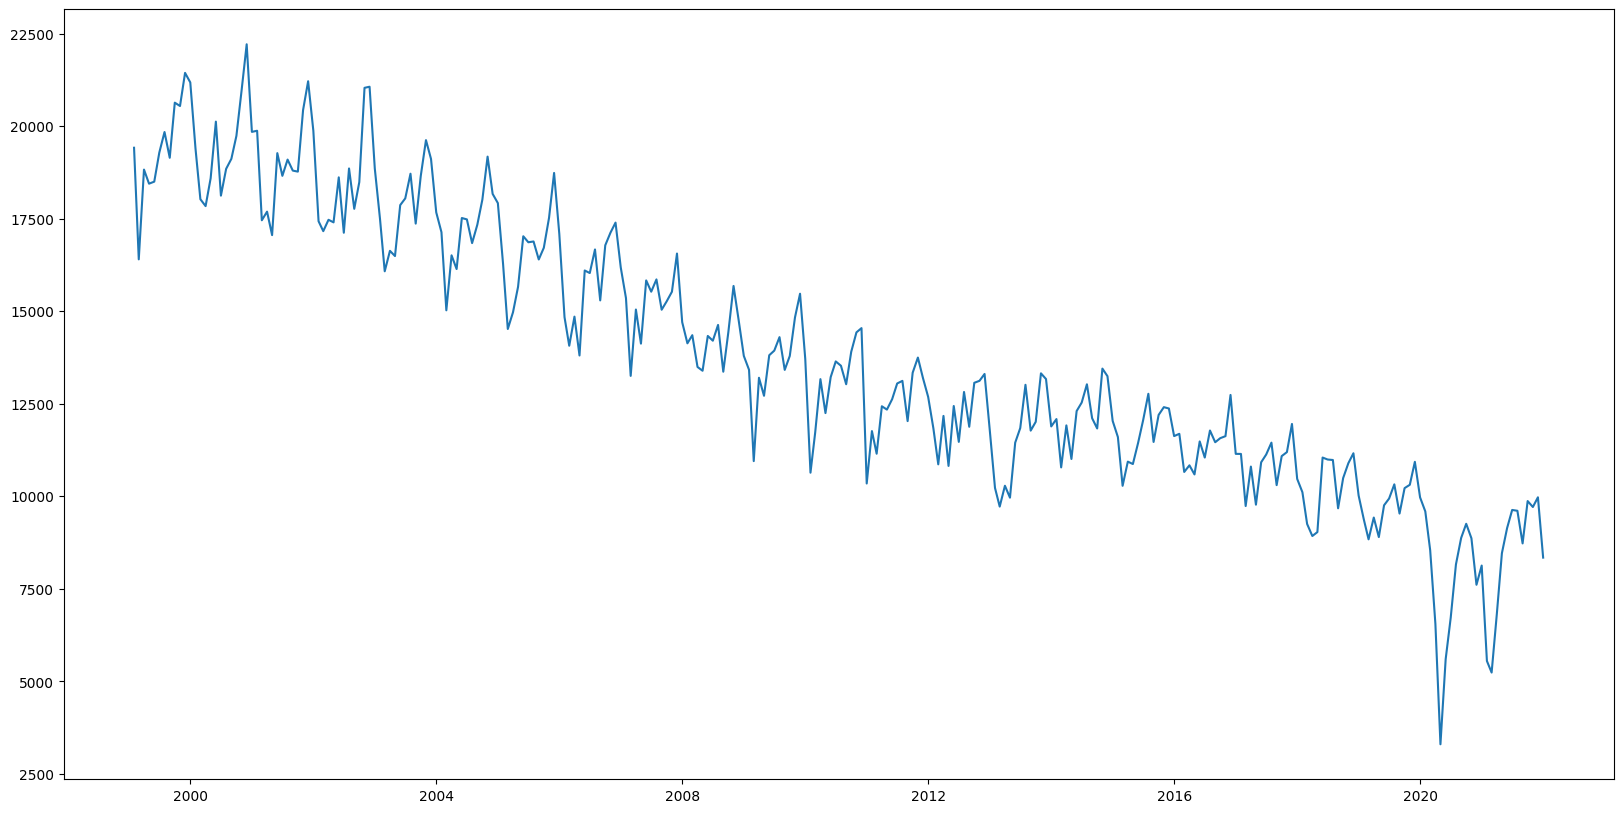

In [7]:
plt.figure(figsize=(20,10))
plt.plot(time_series);

Text(0.5, 1.0, 'Multiplicative residuals plot')

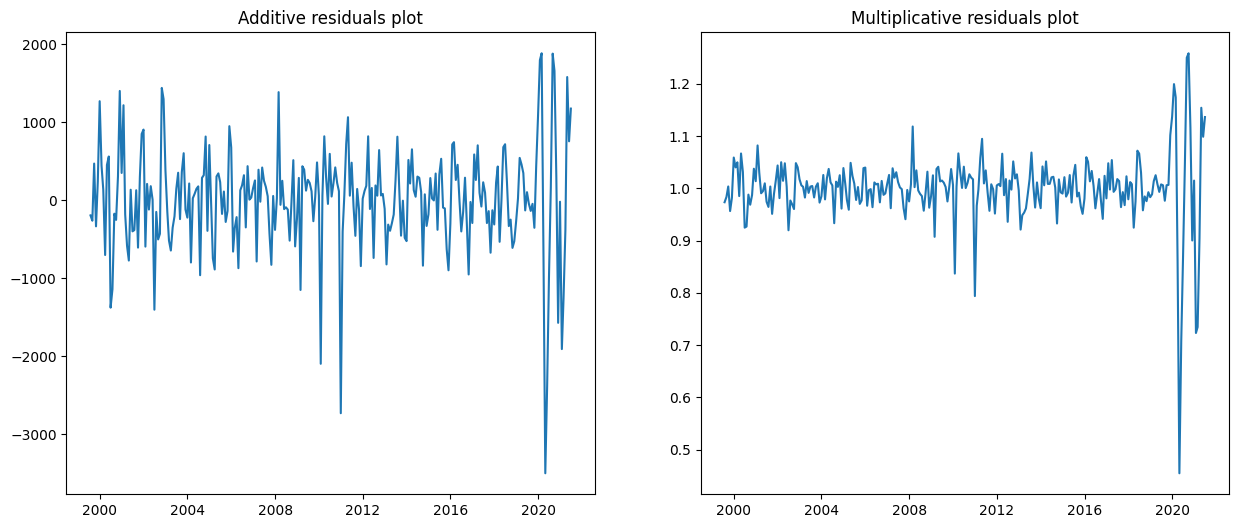

In [9]:
# Seasonal decomposition of the time series using two methods: additive and multiplicative
result_add = seasonal_decompose(time_series['Accidents'], model='additive')
result_mul = seasonal_decompose(time_series['Accidents'], model='multiplicative')
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(result_add.resid)
plt.title('Additive residuals plot')
plt.subplot(1,2,2)
plt.plot(result_mul.resid)
plt.title('Multiplicative residuals plot')

In [10]:
# We choose the additive method, because the residuals are better distributed
time_series['deseasonalized']=time_series['Accidents'].values-result_add.seasonal

<AxesSubplot: xlabel='date', ylabel='seasonal'>

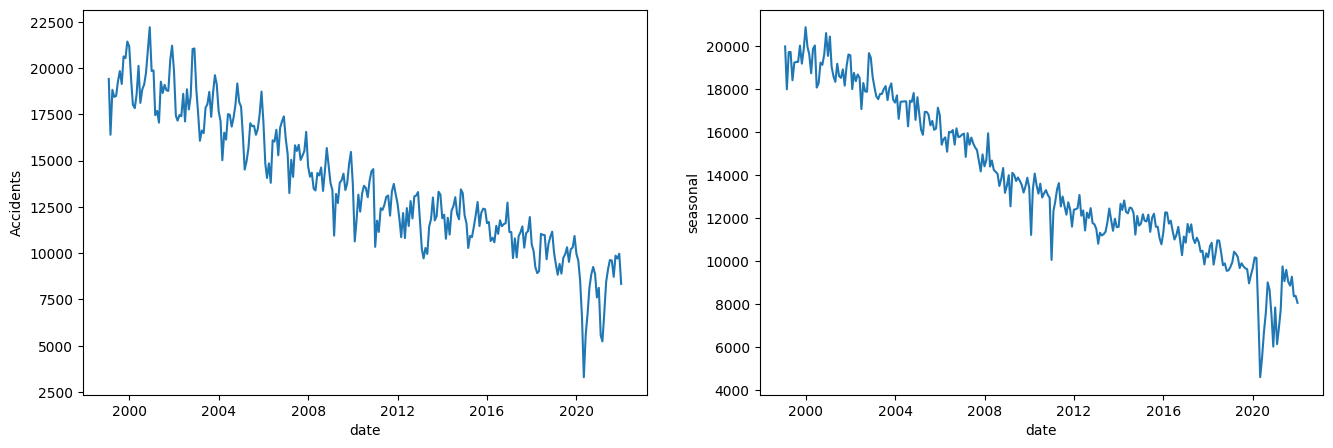

In [11]:
fig, axes = plt.subplots(1,2, figsize=(16,5))

sns.lineplot(time_series['Accidents'], ax=axes[0])
sns.lineplot(time_series['Accidents'].values-result_add.seasonal, ax=axes[1])


In [12]:
# We cut the time series in order to exclude 2020 and 2021, as these will be our prediction target
time_series_2019=time_series.head(time_series.shape[0]-24)
time_series_2019

,Accidents,deseasonalized
date,,
1999-01-31,19418,19999.456439
1999-02-28,16402,18002.244318
1999-03-31,18828,19737.935606
1999-04-30,18447,19738.659091
1999-05-31,18502,18422.369318
...,...,...
2019-08-31,9532,9662.454545
2019-09-30,10220,9620.662879
2019-10-31,10310,8960.787879


In [13]:
# We use the deseasonalized series up until 2019 as train, and 2020 and 2021 as test
train=time_series_2019['deseasonalized']
test=time_series['deseasonalized'][-24:]

In [14]:
# We look for the best parameters for our ARIMA model
smodel = pm.auto_arima(train,
                       start_p=1, max_p=4,
                       start_q=1, max_q=25,
                       trend='t',
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3938.262, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4008.556, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3964.944, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3944.222, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4008.556, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3939.535, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3939.980, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3940.138, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3955.071, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3940.568, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3938.262, Time=0.14 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.429 seconds


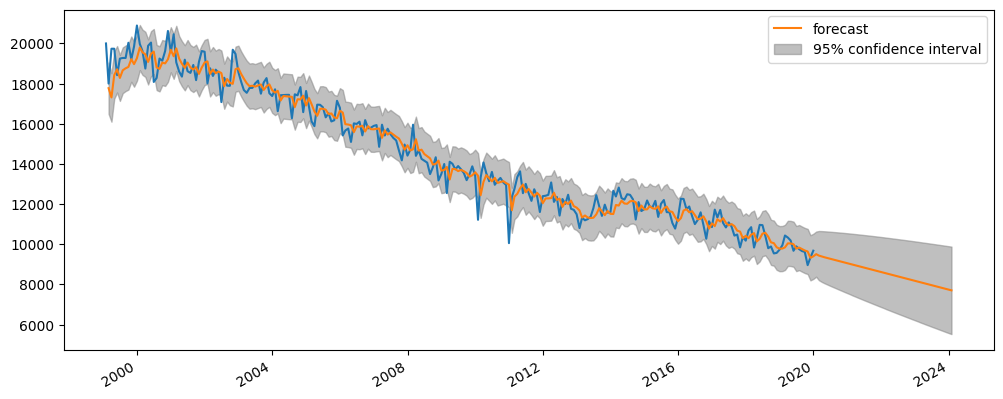

In [15]:
# We train the model using the parameters identified in the previous step
arima_2019 = ARIMA(train, order=(1, 1, 1), trend='t')
arima_2019 = arima_2019.fit()

# We plot the prediction for the following years (deseasonalized)
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(train)
plot_predict(arima_2019, start=1, end=300, ax=axs);

In [17]:
# We calculate the forecatsed values for 2020 and 2021, as well as the confidence intervals for the prediction
forecast_results = arima_2019.get_forecast(len(test), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values

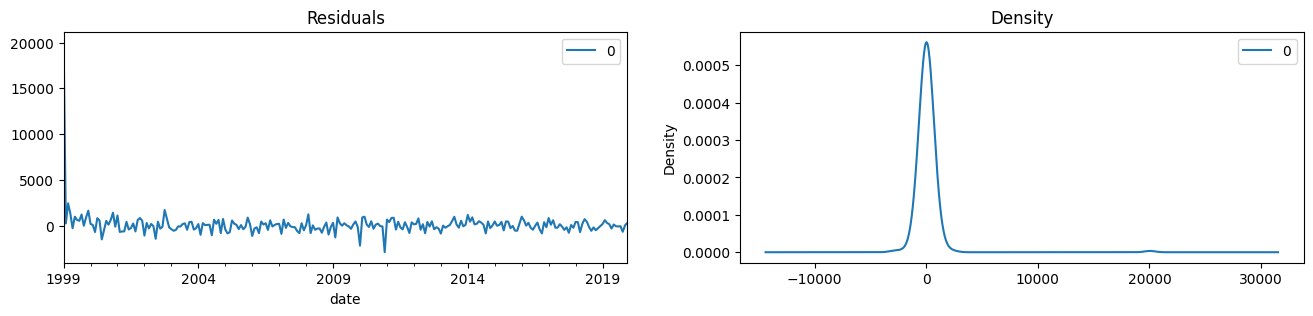

In [18]:
# We check the distribution of the residuals, to ensure statistical relevance of the model

residuals = pd.DataFrame(arima_2019.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);

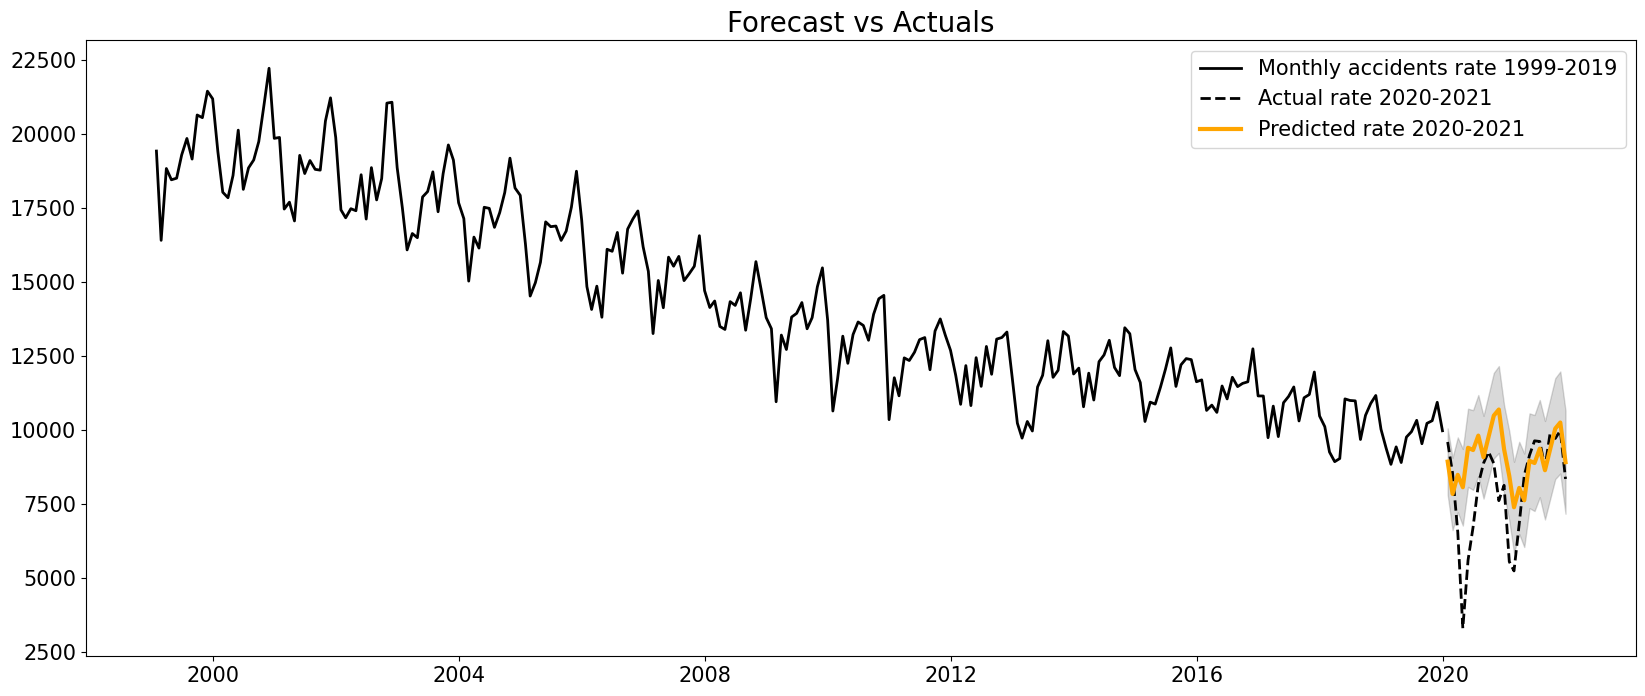

In [19]:
# To compare the forecasts with the seasonalized data, we add back the seasonality to the forcecasts
forecast_recons = forecast + result_add.seasonal[len(train):]
train_recons = train+ result_add.seasonal[0:len(train)]
test_recons = test+result_add.seasonal[len(train):]
lower_recons =confidence_int[:, 0]+ result_add.seasonal[len(train):]
upper_recons = confidence_int[:, 1] + result_add.seasonal[len(train):]

# Plot of the origial time series as well as the forecasts, including the effects of seasonality
plt.figure(figsize=(20,8))
plt.plot(train_recons, label='Monthly accidents rate 1999-2019', color='black',linewidth=2)
plt.plot(test_recons, label='Actual rate 2020-2021', color='black', ls='--',linewidth=2)
plt.plot(forecast_recons, label='Predicted rate 2020-2021', color='orange',linewidth=3)
plt.fill_between(lower_recons.index, lower_recons, upper_recons, color='k', alpha=.15)
plt.title('Forecast vs Actuals',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15);